In [1]:
import torch
import torch.nn as nn
import torchvision
import pandas as pd
import numpy as np
import zipfile
import io
import pandas as pd
import math
from IPython.display import display
from collections import defaultdict

zipped_data_path = "../data/clean_data/class-competition-cleaned.zip"

dataframes = defaultdict(pd.DataFrame)
with zipfile.ZipFile(zipped_data_path, "r") as zipf:
    for filename in zipf.namelist():
        if filename.endswith(".csv"):
            with zipf.open(filename) as f:
                dataframes.update({ filename : pd.read_csv(io.TextIOWrapper(f)) })

                # Lets take a look at the files
                print(f"FILE: {filename}")
                # If you want to see file info uncomment this:
                # display(dataframes[filename].info())
                # display(dataframes[filename].head())

FILE: train_call_type_A.csv
FILE: train_call_type_B.csv
FILE: train_call_type_C.csv
FILE: test_public.csv


In [4]:
train_data_A = dataframes["train_call_type_A.csv"]
train_data_B = dataframes["train_call_type_B.csv"]
train_data_C = dataframes["train_call_type_C.csv"]
test_data  = dataframes["test_public.csv"]
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [3]:
from sklearn.preprocessing import StandardScaler

# Split the START_LOCATION into two new columns for latitude and longitude for train set
for i, j in train_data_B['START_LOCATION'].items():
    split = j.split(',')
    train_data_B.at[i, 'START_LAT'] = split[0]
    train_data_B.at[i, 'START_LONG'] = split[1]

# Use only data points with CALL_TYPE B
# Split the START_LOCATION into two new columns for latitude and longitude for test set
for i, j in test_data['START_LOCATION'].items():
    if not isinstance(j, str):
        test_data.at[i, 'START_LAT'] = 41.1564349 # MEAN
        test_data.at[i, 'START_LONG'] = -8.61451627 # MEAN
    else:
        split = j.split(',')
        test_data.at[i, 'START_LAT'] = split[0]
        test_data.at[i, 'START_LONG'] = split[1]

latitude_train = pd.DataFrame(train_data_B['START_LAT'].astype(float))
longitude_train = pd.DataFrame(train_data_B['START_LONG'].astype(float))
latitude_test = pd.DataFrame(test_data['START_LAT'].astype(float))
longitude_test = pd.DataFrame(test_data['START_LONG'].astype(float))

lat_scaler = StandardScaler()
lat_scaler.fit(latitude_train)

normalized_latitude_train = lat_scaler.transform(latitude_train)
normalized_latitude_test = lat_scaler.transform(latitude_test)

long_scaler = StandardScaler()
long_scaler.fit(longitude_train)

normalized_longitude_train = long_scaler.transform(longitude_train)
normalized_longitude_test = long_scaler.transform(longitude_test)

train_data_B.loc[:, 'START_LAT_NORMALIZED'] = normalized_latitude_train
train_data_B.loc[:, 'START_LONG_NORMALIZED'] = normalized_longitude_train
test_data.loc[:, 'START_LAT_NORMALIZED'] = normalized_latitude_test
test_data.loc[:, 'START_LONG_NORMALIZED'] = normalized_longitude_test

In [156]:
merged_df = pd.merge(train_data_A.drop('START_LOCATION', axis=1), train_data_B, how='outer')
merged_df = pd.merge(merged_df, train_data_C.drop('START_LOCATION', axis=1), how='outer')

merged_df['START_LONG_NORMALIZED'].fillna(train_data_B['START_LONG_NORMALIZED'].mean(), inplace=True)
merged_df['START_LAT_NORMALIZED'].fillna(train_data_B['START_LAT_NORMALIZED'].mean(), inplace=True)

In [157]:
from sklearn.preprocessing import LabelEncoder

def encode(col, train, test):
	labelEncoder = LabelEncoder()

	train_vals, test_vals = train[col].copy(), test[col].copy()
	train_vals[np.isnan(train_vals)], test_vals[np.isnan(test_vals)] = 0, 0
	merge = pd.concat([train_vals, test_vals])

	labelEncoder.fit(merge)
	
	train[col + "_ENCODED"] = labelEncoder.transform(train_vals)
	test[col + "_ENCODED"] = labelEncoder.transform(test_vals)
	return labelEncoder

taxi_id_encoder = encode('TAXI_ID', merged_df, test_data)
origin_call_encoder = encode('ORIGIN_CALL', merged_df, test_data)
origin_stand_encoder = encode('ORIGIN_STAND', merged_df, test_data)

In [161]:
from sklearn.model_selection import train_test_split

# We could totally change this. Utilization of these just probably requires further preprocessing.
ALL_FEATURES_NOT_SUITED_FOR_ESTIMATION = ['TRIP_ID', 'CALL_TYPE', 'ORIGIN_CALL', 'ORIGIN_STAND', 'POLYLINE', 'START_LOCATION', 'TAXI_ID', 'START_LAT', 'START_LONG',  'DATE', 'YR_2013']

X = merged_df.drop("TRAVEL_TIME", axis=1)
X = X.loc[:, ~X.columns.isin(ALL_FEATURES_NOT_SUITED_FOR_ESTIMATION)]
y = merged_df["TRAVEL_TIME"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.02, random_state=420, shuffle=True)

test_features = test_data.loc[:, ~test_data.columns.isin(ALL_FEATURES_NOT_SUITED_FOR_ESTIMATION)]

In [162]:
y.mean()

702.4254278472528

In [163]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286434 entries, 0 to 286433
Data columns (total 20 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             286434 non-null  int64  
 1   TIMESTAMP              286434 non-null  int64  
 2   MON_sin                286434 non-null  float64
 3   MON_cos                286434 non-null  float64
 4   DAY_sin                286434 non-null  float64
 5   DAY_cos                286434 non-null  float64
 6   HR_sin                 286434 non-null  float64
 7   HR_cos                 286434 non-null  float64
 8   WK_sin                 286434 non-null  float64
 9   WK_cos                 286434 non-null  float64
 10  DATE_2014-08-14        286434 non-null  bool   
 11  DATE_2014-09-30        286434 non-null  bool   
 12  DATE_2014-10-06        286434 non-null  bool   
 13  DATE_2014-10-31        286434 non-null  bool   
 14  DATE_2014-12-21        286434 non-nu

In [166]:
from torch.utils.data import DataLoader, Dataset
from mlp_utils import TaxiDataset

# Separate the boolean columns
boolean_cols = ['DATE_2014-08-14','DATE_2014-09-30','DATE_2014-10-06','DATE_2014-10-31','DATE_2014-12-21']

# Separate the float columns
float_cols = ['DAY_sin', 'DAY_cos', 'HR_sin', 'HR_cos', 'WK_sin', 'WK_cos', 'MON_sin', 'MON_cos', 'START_LAT_NORMALIZED', 'START_LONG_NORMALIZED',]

# Separate the encoded columns
encoded_cols = ['TAXI_ID_ENCODED', 'ORIGIN_CALL_ENCODED', 'ORIGIN_STAND_ENCODED']

# Boolean columns
train_boolean_data = X_train[boolean_cols].astype(int).values
test_boolean_data = X_test[boolean_cols].astype(int).values
test_public_boolean_data = test_features[boolean_cols].astype(int).values

# Float columns
train_float_data = X_train[float_cols].astype(float).values
test_float_data = X_test[float_cols].astype(int).values
test_public_float_data = test_features[float_cols].astype(int).values

# Encoded columns
train_encoded_data = X_train[encoded_cols].astype(int).values
test_encoded_data = X_test[encoded_cols].astype(int).values
test_public_encoded_data = test_features[encoded_cols].astype(int).values

train_concat = np.concatenate((train_boolean_data, train_float_data, train_encoded_data), axis=1)
test_concat = np.concatenate((test_boolean_data, test_float_data, test_encoded_data), axis=1)
test_public_concat = np.concatenate((test_public_boolean_data, test_public_float_data, test_public_encoded_data), axis=1)

X_train_tensor = torch.tensor(train_concat, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.tolist(), dtype=torch.float32)
X_test_tensor = torch.tensor(test_concat, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.tolist(), dtype=torch.float32)
X_test_public_tensor = torch.tensor(test_public_concat, dtype=torch.float32)

train_dataset = TaxiDataset(X_train_tensor, y_train_tensor)
test_dataset = TaxiDataset(X_test_tensor, y_test_tensor)
test_public_dataset = TaxiDataset(X_test_public_tensor)

batch_size = 256

dataloader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dataloader_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
dataloader_pred = DataLoader(test_public_dataset, batch_size=batch_size)

In [169]:
import torch.nn.functional as F

class MLP(nn.Module):
  '''
    Multilayer Perceptron for regression.
  '''
  def __init__(self):
    super().__init__()
    self.embed_taxi_id = nn.Embedding(len(taxi_id_encoder.classes_), 20)
    self.embed_origin_call = nn.Embedding(len(origin_call_encoder.classes_), 20)
    self.embed_origin_stand = nn.Embedding(len(origin_stand_encoder.classes_), 20)
    self.dropout1 = nn.Dropout(0.5)
    self.fc1 = nn.Linear(75, 128)
    self.dropout2 = nn.Dropout(0.5)
    self.fc2 = nn.Linear(128, 64)
    self.dropout3 = nn.Dropout(0.5)
    self.fc3 = nn.Linear(64, 32)
    self.dropout4 = nn.Dropout(0.3)
    self.fc4 = nn.Linear(32, 16)
    self.fc5 = nn.Linear(16, 1)

  def forward(self, x):
    '''
      Forward pass
    '''
    taxi_id = self.embed_taxi_id(x[:, -3].to(torch.int32))
    origin_call = self.embed_origin_call(x[:, -2].to(torch.int32))
    origin_stand = self.embed_origin_stand(x[:, -1].to(torch.int32))
    x = torch.cat([taxi_id, origin_call, origin_stand, x[:, :-3]], axis=1).to(torch.float32)
    x = self.dropout1(x)
    x = F.relu(self.fc1(x))
    x = self.dropout2(x)
    x = F.relu(self.fc2(x))
    x = self.dropout3(x)
    x = F.relu(self.fc3(x))
    x = self.dropout4(x)
    x = F.relu(self.fc4(x))
    x = self.fc5(x)
    return x

In [170]:
from mlp_utils import num_parameters

mlp = MLP()
if torch.cuda.is_available():
    mlp.cuda()
 
num_parameters(mlp)

437289

In [171]:
from mlp_utils import pipeline
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(mlp.parameters(), lr=0.001, weight_decay=1e-5)

train_losses, test_loss, predictions = pipeline(mlp, optimizer, dataloader_train=dataloader_train, 
                                                dataloader_test=dataloader_test, dataloader_pred=dataloader_pred,
                        			device=device, criterion=criterion, epochs=100, verbose=True)

  1%|          | 1/100 [00:06<10:27,  6.34s/it]

Epoch 1 - Train Loss = 488.60946335788987


  2%|▏         | 2/100 [00:12<09:55,  6.08s/it]

Epoch 2 - Train Loss = 449.9211962708646


  3%|▎         | 3/100 [00:18<09:41,  6.00s/it]

Epoch 3 - Train Loss = 445.79503856252387


  4%|▍         | 4/100 [00:24<09:39,  6.04s/it]

Epoch 4 - Train Loss = 442.9435866312829


  5%|▌         | 5/100 [00:30<09:36,  6.07s/it]

Epoch 5 - Train Loss = 440.2012243035047


  6%|▌         | 6/100 [00:36<09:26,  6.03s/it]

Epoch 6 - Train Loss = 437.73324653938676


  7%|▋         | 7/100 [00:42<09:19,  6.02s/it]

Epoch 7 - Train Loss = 434.96490568470205


  8%|▊         | 8/100 [00:48<09:12,  6.01s/it]

Epoch 8 - Train Loss = 431.9983821933781


  9%|▉         | 9/100 [00:54<09:06,  6.00s/it]

Epoch 9 - Train Loss = 429.0523086112806


 10%|█         | 10/100 [01:00<09:03,  6.03s/it]

Epoch 10 - Train Loss = 426.464918779869


 11%|█         | 11/100 [01:06<08:53,  6.00s/it]

Epoch 11 - Train Loss = 424.5854873218413


 12%|█▏        | 12/100 [01:12<08:41,  5.92s/it]

Epoch 12 - Train Loss = 422.85099772706184


 13%|█▎        | 13/100 [01:17<08:33,  5.90s/it]

Epoch 13 - Train Loss = 421.86877996022366


 14%|█▍        | 14/100 [01:23<08:31,  5.95s/it]

Epoch 14 - Train Loss = 420.73849692921686


 15%|█▌        | 15/100 [01:29<08:23,  5.92s/it]

Epoch 15 - Train Loss = 419.5792586391027


 16%|█▌        | 16/100 [01:35<08:15,  5.90s/it]

Epoch 16 - Train Loss = 418.571558890103


 17%|█▋        | 17/100 [01:41<08:10,  5.91s/it]

Epoch 17 - Train Loss = 417.50107238097746


 18%|█▊        | 18/100 [01:47<08:05,  5.92s/it]

Epoch 18 - Train Loss = 416.3879753090132


 19%|█▉        | 19/100 [01:53<08:00,  5.93s/it]

Epoch 19 - Train Loss = 415.17140749504046


 20%|██        | 20/100 [01:59<07:56,  5.96s/it]

Epoch 20 - Train Loss = 414.55785432651993


 21%|██        | 21/100 [02:05<07:52,  5.98s/it]

Epoch 21 - Train Loss = 413.4984493619923


 22%|██▏       | 22/100 [02:11<07:44,  5.96s/it]

Epoch 22 - Train Loss = 412.7777730570319


 23%|██▎       | 23/100 [02:17<07:36,  5.93s/it]

Epoch 23 - Train Loss = 412.11528399191644


 24%|██▍       | 24/100 [02:23<07:28,  5.90s/it]

Epoch 24 - Train Loss = 411.13613525352037


 25%|██▌       | 25/100 [02:29<07:21,  5.89s/it]

Epoch 25 - Train Loss = 410.4842292097499


 26%|██▌       | 26/100 [02:34<07:17,  5.91s/it]

Epoch 26 - Train Loss = 409.84420823727413


 27%|██▋       | 27/100 [02:40<07:09,  5.89s/it]

Epoch 27 - Train Loss = 409.37741773347165


 28%|██▊       | 28/100 [02:46<07:04,  5.90s/it]

Epoch 28 - Train Loss = 408.615627932914


 29%|██▉       | 29/100 [02:52<06:59,  5.90s/it]

Epoch 29 - Train Loss = 408.3496102767763


 30%|███       | 30/100 [02:58<06:54,  5.92s/it]

Epoch 30 - Train Loss = 407.9940296190166


 31%|███       | 31/100 [03:04<06:48,  5.91s/it]

Epoch 31 - Train Loss = 407.5775416564096


 32%|███▏      | 32/100 [03:10<06:40,  5.89s/it]

Epoch 32 - Train Loss = 407.0375408116022


 33%|███▎      | 33/100 [03:16<06:37,  5.93s/it]

Epoch 33 - Train Loss = 406.84897977877


 34%|███▍      | 34/100 [03:22<06:32,  5.95s/it]

Epoch 34 - Train Loss = 406.4742586004644


 35%|███▌      | 35/100 [03:28<06:28,  5.98s/it]

Epoch 35 - Train Loss = 406.1673906612325


 36%|███▌      | 36/100 [03:34<06:22,  5.98s/it]

Epoch 36 - Train Loss = 405.7403347655251


 37%|███▋      | 37/100 [03:40<06:16,  5.98s/it]

Epoch 37 - Train Loss = 405.44712370620977


 38%|███▊      | 38/100 [03:46<06:06,  5.92s/it]

Epoch 38 - Train Loss = 405.0818597760057


 39%|███▉      | 39/100 [03:52<05:59,  5.90s/it]

Epoch 39 - Train Loss = 404.95937914382466


 40%|████      | 40/100 [03:57<05:53,  5.89s/it]

Epoch 40 - Train Loss = 404.59858107483666


 41%|████      | 41/100 [04:03<05:47,  5.90s/it]

Epoch 41 - Train Loss = 404.3119418409933


 42%|████▏     | 42/100 [04:09<05:41,  5.89s/it]

Epoch 42 - Train Loss = 404.16033955501234


 43%|████▎     | 43/100 [04:15<05:35,  5.88s/it]

Epoch 43 - Train Loss = 403.8562920297392


 44%|████▍     | 44/100 [04:21<05:28,  5.86s/it]

Epoch 44 - Train Loss = 403.7579509265638


 45%|████▌     | 45/100 [04:27<05:22,  5.86s/it]

Epoch 45 - Train Loss = 403.53306791609725


 46%|████▌     | 46/100 [04:33<05:16,  5.86s/it]

Epoch 46 - Train Loss = 403.5509830712656


 47%|████▋     | 47/100 [04:39<05:11,  5.88s/it]

Epoch 47 - Train Loss = 403.1898793480347


 48%|████▊     | 48/100 [04:44<05:05,  5.88s/it]

Epoch 48 - Train Loss = 403.034524209552


 49%|████▉     | 49/100 [04:50<05:00,  5.88s/it]

Epoch 49 - Train Loss = 402.8815526402054


 50%|█████     | 50/100 [04:56<04:55,  5.91s/it]

Epoch 50 - Train Loss = 402.4864744786064


 51%|█████     | 51/100 [05:02<04:47,  5.88s/it]

Epoch 51 - Train Loss = 402.27290856303614


 52%|█████▏    | 52/100 [05:08<04:41,  5.87s/it]

Epoch 52 - Train Loss = 401.99974995223164


 53%|█████▎    | 53/100 [05:14<04:36,  5.88s/it]

Epoch 53 - Train Loss = 402.22115019401974


 54%|█████▍    | 54/100 [05:20<04:31,  5.90s/it]

Epoch 54 - Train Loss = 401.9381024832521


 55%|█████▌    | 55/100 [05:26<04:25,  5.91s/it]

Epoch 55 - Train Loss = 401.7609139587361


 56%|█████▌    | 56/100 [05:32<04:20,  5.91s/it]

Epoch 56 - Train Loss = 401.75817558783245


 57%|█████▋    | 57/100 [05:37<04:12,  5.87s/it]

Epoch 57 - Train Loss = 401.28882996253526


 58%|█████▊    | 58/100 [05:43<04:07,  5.89s/it]

Epoch 58 - Train Loss = 401.44392893581187


 59%|█████▉    | 59/100 [05:49<04:01,  5.90s/it]

Epoch 59 - Train Loss = 401.136998525976


 60%|██████    | 60/100 [05:55<03:56,  5.90s/it]

Epoch 60 - Train Loss = 401.0157961157294


 61%|██████    | 61/100 [06:01<03:52,  5.96s/it]

Epoch 61 - Train Loss = 400.9102677852409


 62%|██████▏   | 62/100 [06:07<03:45,  5.93s/it]

Epoch 62 - Train Loss = 400.8547221301567


 63%|██████▎   | 63/100 [06:13<03:38,  5.91s/it]

Epoch 63 - Train Loss = 400.7016596267504


 64%|██████▍   | 64/100 [06:19<03:33,  5.93s/it]

Epoch 64 - Train Loss = 400.6254819551779


 65%|██████▌   | 65/100 [06:25<03:27,  5.93s/it]

Epoch 65 - Train Loss = 400.67018130180765


 66%|██████▌   | 66/100 [06:31<03:22,  5.95s/it]

Epoch 66 - Train Loss = 400.2735910844395


 67%|██████▋   | 67/100 [06:37<03:16,  5.96s/it]

Epoch 67 - Train Loss = 400.1797544343808


 68%|██████▊   | 68/100 [06:43<03:11,  5.98s/it]

Epoch 68 - Train Loss = 400.1672468357709


 69%|██████▉   | 69/100 [06:49<03:04,  5.95s/it]

Epoch 69 - Train Loss = 399.9845893955556


 70%|███████   | 70/100 [06:55<02:57,  5.93s/it]

Epoch 70 - Train Loss = 399.63294794703006


 71%|███████   | 71/100 [07:01<02:52,  5.96s/it]

Epoch 71 - Train Loss = 399.70211391533957


 72%|███████▏  | 72/100 [07:07<02:46,  5.95s/it]

Epoch 72 - Train Loss = 399.53338035442533


 73%|███████▎  | 73/100 [07:12<02:40,  5.94s/it]

Epoch 73 - Train Loss = 399.5079040323066


 74%|███████▍  | 74/100 [07:18<02:34,  5.92s/it]

Epoch 74 - Train Loss = 399.333622067057


 75%|███████▌  | 75/100 [07:24<02:27,  5.92s/it]

Epoch 75 - Train Loss = 399.2414450440503


 76%|███████▌  | 76/100 [07:30<02:22,  5.92s/it]

Epoch 76 - Train Loss = 399.06634992653454


 77%|███████▋  | 77/100 [07:36<02:15,  5.89s/it]

Epoch 77 - Train Loss = 398.96606918442546


 78%|███████▊  | 78/100 [07:42<02:09,  5.89s/it]

Epoch 78 - Train Loss = 398.8403458283995


 79%|███████▉  | 79/100 [07:48<02:03,  5.90s/it]

Epoch 79 - Train Loss = 398.8034370243862


 80%|████████  | 80/100 [07:54<01:58,  5.93s/it]

Epoch 80 - Train Loss = 398.69890699561


 81%|████████  | 81/100 [08:00<01:52,  5.92s/it]

Epoch 81 - Train Loss = 398.7991351002122


 82%|████████▏ | 82/100 [08:06<01:46,  5.90s/it]

Epoch 82 - Train Loss = 398.7937027227966


 83%|████████▎ | 83/100 [08:11<01:39,  5.87s/it]

Epoch 83 - Train Loss = 398.4431434217027


 84%|████████▍ | 84/100 [08:17<01:34,  5.89s/it]

Epoch 84 - Train Loss = 398.4039033997179


 85%|████████▌ | 85/100 [08:23<01:28,  5.89s/it]

Epoch 85 - Train Loss = 398.580847714376


 86%|████████▌ | 86/100 [08:29<01:22,  5.90s/it]

Epoch 86 - Train Loss = 398.25772942795624


 87%|████████▋ | 87/100 [08:35<01:16,  5.92s/it]

Epoch 87 - Train Loss = 398.2566633834929


 88%|████████▊ | 88/100 [08:41<01:11,  5.94s/it]

Epoch 88 - Train Loss = 398.3531435581751


 89%|████████▉ | 89/100 [08:47<01:05,  5.95s/it]

Epoch 89 - Train Loss = 398.1800282507053


 90%|█████████ | 90/100 [08:53<00:59,  5.91s/it]

Epoch 90 - Train Loss = 398.13394615329156


 91%|█████████ | 91/100 [08:59<00:53,  5.93s/it]

Epoch 91 - Train Loss = 397.9776252404159


 92%|█████████▏| 92/100 [09:05<00:47,  5.96s/it]

Epoch 92 - Train Loss = 397.66268491949495


 93%|█████████▎| 93/100 [09:11<00:41,  5.96s/it]

Epoch 93 - Train Loss = 398.1866648950884


 94%|█████████▍| 94/100 [09:17<00:35,  5.94s/it]

Epoch 94 - Train Loss = 397.98438579675985


 95%|█████████▌| 95/100 [09:23<00:29,  5.94s/it]

Epoch 95 - Train Loss = 397.74157864688294


 96%|█████████▌| 96/100 [09:29<00:23,  5.92s/it]

Epoch 96 - Train Loss = 397.7405802621504


 97%|█████████▋| 97/100 [09:35<00:17,  5.99s/it]

Epoch 97 - Train Loss = 397.61133639048904


 98%|█████████▊| 98/100 [09:41<00:11,  5.98s/it]

Epoch 98 - Train Loss = 397.71358092709306


 99%|█████████▉| 99/100 [09:47<00:05,  5.97s/it]

Epoch 99 - Train Loss = 397.45544672895676


100%|██████████| 100/100 [09:53<00:00,  5.93s/it]

Epoch 100 - Train Loss = 397.4119543302198
Training process has finished.


In [172]:
print(f"Final Train Loss: {train_losses[-1]}")
print(f"Test Loss: {test_loss}")

Final Train Loss: 397.4119543302198
Test Loss: 421.73393374207535


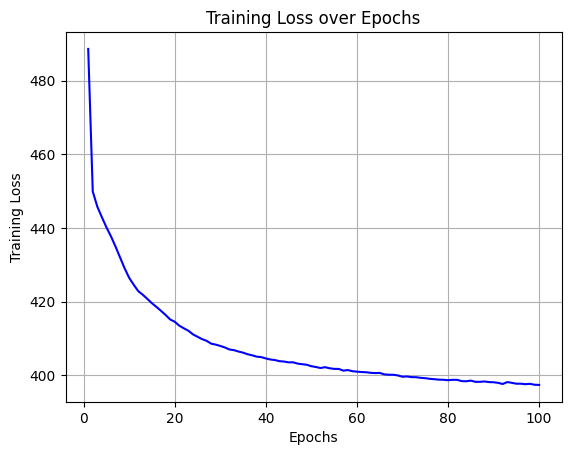

[488.60946335788987, 449.9211962708646, 445.79503856252387, 442.9435866312829, 440.2012243035047, 437.73324653938676, 434.96490568470205, 431.9983821933781, 429.0523086112806, 426.464918779869, 424.5854873218413, 422.85099772706184, 421.86877996022366, 420.73849692921686, 419.5792586391027, 418.571558890103, 417.50107238097746, 416.3879753090132, 415.17140749504046, 414.55785432651993, 413.4984493619923, 412.7777730570319, 412.11528399191644, 411.13613525352037, 410.4842292097499, 409.84420823727413, 409.37741773347165, 408.615627932914, 408.3496102767763, 407.9940296190166, 407.5775416564096, 407.0375408116022, 406.84897977877, 406.4742586004644, 406.1673906612325, 405.7403347655251, 405.44712370620977, 405.0818597760057, 404.95937914382466, 404.59858107483666, 404.3119418409933, 404.16033955501234, 403.8562920297392, 403.7579509265638, 403.53306791609725, 403.5509830712656, 403.1898793480347, 403.034524209552, 402.8815526402054, 402.4864744786064, 402.27290856303614, 401.999749952231

In [173]:
import matplotlib.pyplot as plt

# Create x-axis values (epochs)
epochs = range(1, len(train_losses) + 1)

# Plot the training loss
plt.plot(epochs, train_losses, 'b-')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.show()

print(train_losses)

In [174]:
from mlp_utils import test_prediction_to_csv

test_prediction_to_csv(predictions, "mlp_encoding_layers_concatenated.csv", test_data)